In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, randint
from sklearn.metrics import roc_curve, auc
from category_encoders import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from flask import Flask, render_template, request
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import pickle
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')

**Feature Engineering for the Pipeline**

In [71]:
# Load data set and target variable

df = pd.read_csv('data/leads.csv')
target_variable = 'Converted'
missing_values = df.isnull().sum()
print(missing_values)

Prospect ID                            0
Lead Number                            0
Lead Origin                            0
Lead Source                            0
Do Not Email                           0
Do Not Call                            0
TotalVisits                          137
Total Time Spent on Website            0
Page Views Per Visit                 137
Last Activity                        986
Country                              907
Industry                            1438
How did you hear about us           2207
Search                                 0
Magazine                               0
Newspaper Article                      0
Forums                                 0
Newspaper                              0
Digital Advertisement                  0
Through Recommendations                0
Product Interested                     0
Lead Quality                        4767
Lead Profile                        2709
Asymmetrique Activity Index         4218
Asymmetrique Pro

In [72]:
# Dropping irrelevant columns
df.drop(['Prospect ID', 'Lead Number'], axis=1, inplace=True)

In [73]:
# Convert Yes/No columns to 1/0

def binary_map(feature):
    return feature.map({'Yes':1, 'No':0})
binary_list = ['Do Not Email', 'Do Not Call', 'Search', 'Magazine', 'Forums', 'Newspaper', 'Digital Advertisement', 'Through Recommendations']
df[binary_list] = df[binary_list].apply(binary_map)

In [74]:
# Identify categorical features

categorical_columns = df.select_dtypes(include=['object']).columns

In [75]:
# Initialize SimpleImputer with strategy='most_frequent' for missing categorical variables

imputer = SimpleImputer(strategy='most_frequent')

# Apply imputation to each categorical column

df[categorical_columns] = imputer.fit_transform(df[categorical_columns])

In [76]:
# Identify numerical columns

numerical_columns = df.select_dtypes(include=['number']).columns

In [77]:
# Initialize SimpleImputer with strategy='mean'

imputer = SimpleImputer(strategy='mean')

# Apply imputation to each numerical column

df[numerical_columns] = imputer.fit_transform(df[numerical_columns])

In [78]:
# LabelEncoder

label_encoder = LabelEncoder()

# Apply label encoding to each categorical column

for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])

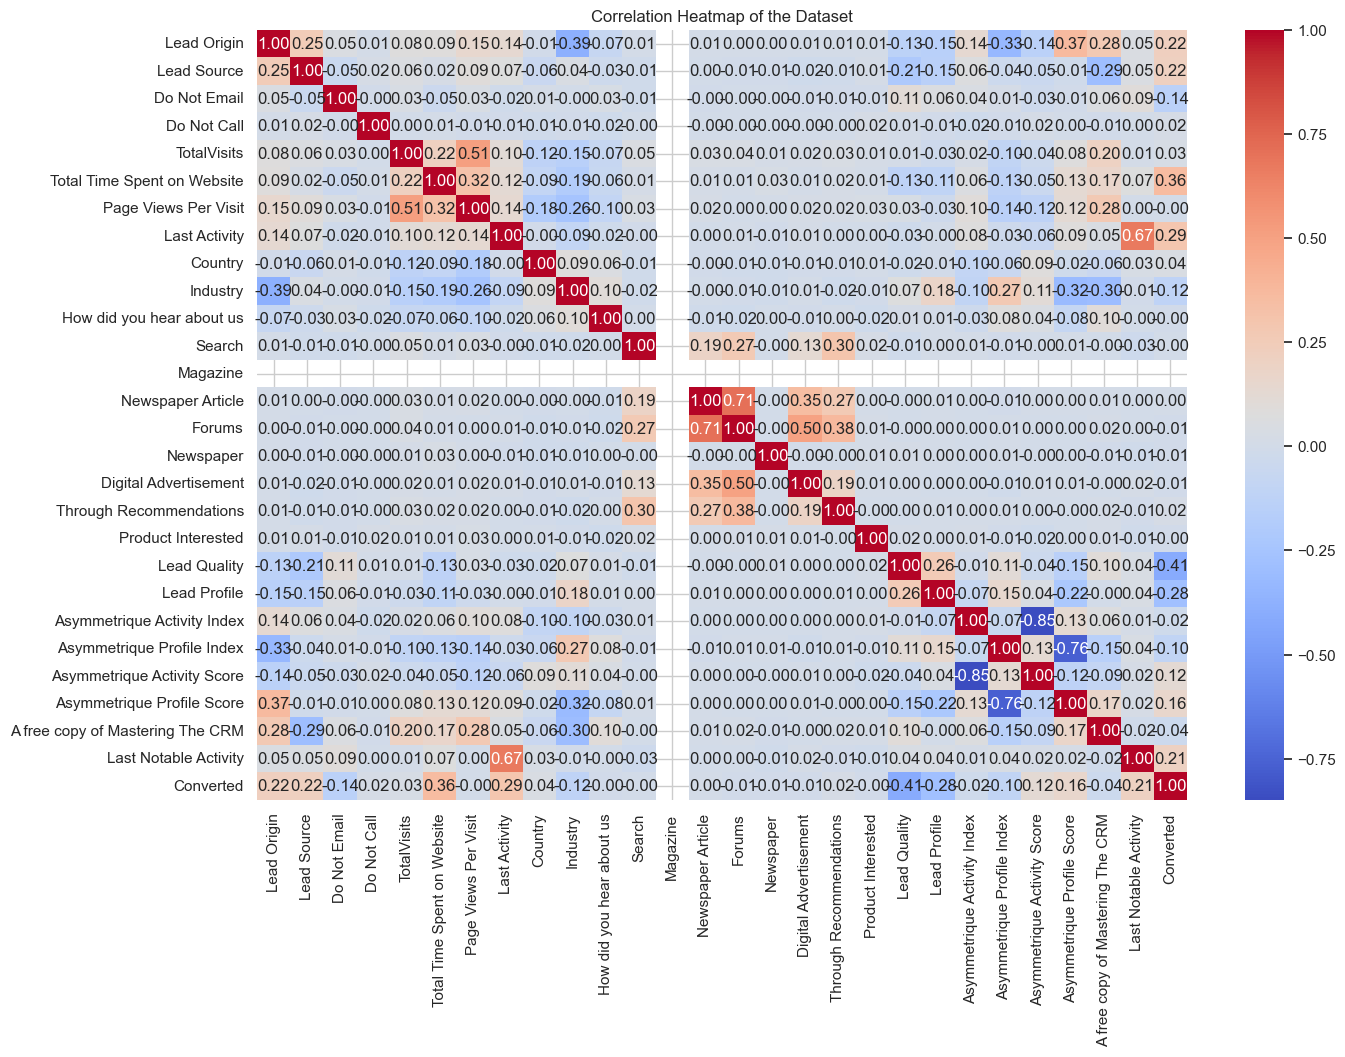

In [79]:
# Correlation Matrix

correlation_matrix = df.corr()

# Plotting the correlation heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of the Dataset')
plt.show()

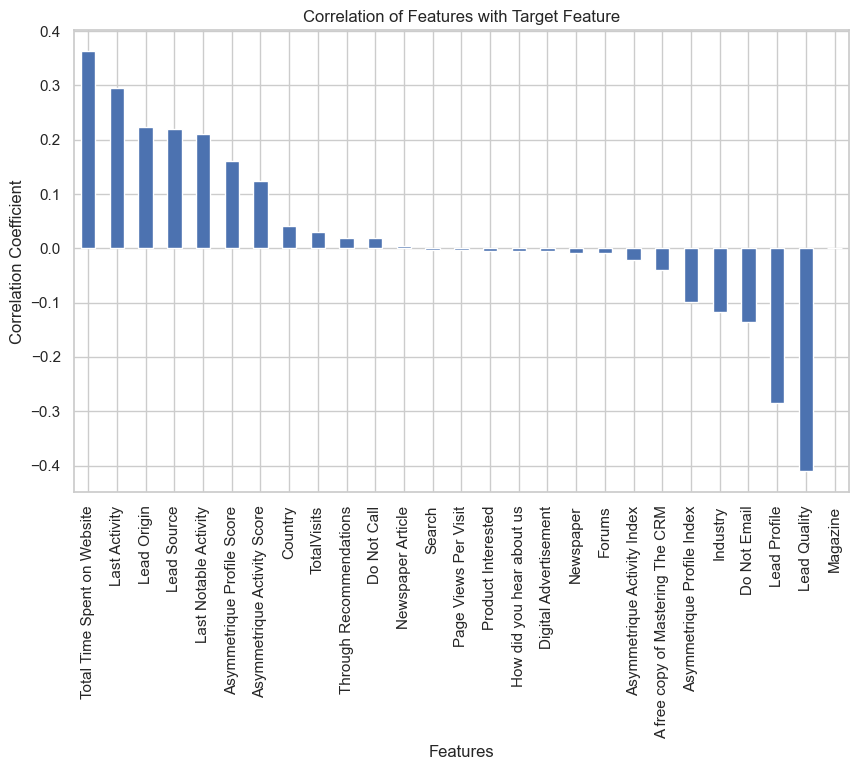

Converted                           1.000000
Total Time Spent on Website         0.362483
Last Activity                       0.294435
Lead Origin                         0.223725
Lead Source                         0.219019
Last Notable Activity               0.210445
Asymmetrique Profile Score          0.160700
Asymmetrique Activity Score         0.123491
Country                             0.041622
TotalVisits                         0.030091
Through Recommendations             0.018607
Do Not Call                         0.018581
Newspaper Article                   0.003465
Search                             -0.002261
Page Views Per Visit               -0.003294
Product Interested                 -0.004704
How did you hear about us          -0.004748
Digital Advertisement              -0.005789
Newspaper                          -0.008238
Forums                             -0.008238
Asymmetrique Activity Index        -0.022031
A free copy of Mastering The CRM   -0.039820
Asymmetriq

In [80]:
# Extracting correlations with target variable

converted_correlations = correlation_matrix['Converted'].sort_values(ascending=False)

# Plotting the correlations with target variable
plt.figure(figsize=(10, 6))
converted_correlations.drop('Converted').plot(kind='bar')
plt.title('Correlation of Features with Target Feature')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.show()

converted_correlations

In [81]:
# Select features

selected_features = ['Total Time Spent on Website', 'Last Activity', 'Lead Origin', 'Lead Source', 'Do Not Email', 'Asymmetrique Profile Score', 'Lead Profile', 'Lead Quality']

In [82]:
# Numerical and categorical features

numerical_features = ['Total Time Spent on Website', 'Asymmetrique Profile Score']

categorical_features = ['Last Activity', 'Lead Origin', 'Lead Source', 'Lead Profile', 'Lead Quality', 'Last Notable Activity']

In [83]:
# Split the data

X = df[numerical_features + categorical_features]
y = df['Converted']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [84]:
# Transformers

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

In [85]:
# Preprocessing

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
     ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

**Baseline Model - Logistic Regression**

In [86]:
# Create a logistic regression pipeline

logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Train the model with training data

logreg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Total Time Spent on '
                                                   'Website',
                                                   'Asymmetrique Profile '
                                                   'Score']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Last Activity',
                                                   'Lead Origin', 'Lead Source',
                                                   'Lead Profile',
                                                   'Lead Quality',
                                                   'Last Notable Activity'])])),
                ('classifier', LogisticRegression())])

In [87]:
# Make predictions with testing data

y_pred = logreg_pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the results
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:\n', classification_rep)

Accuracy: 0.8485
Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.90      0.88      1107
         1.0       0.84      0.77      0.80       741

    accuracy                           0.85      1848
   macro avg       0.85      0.84      0.84      1848
weighted avg       0.85      0.85      0.85      1848



**Random Forest**

In [88]:
# Create a Random Forest classifier pipeline

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('random_forest', RandomForestClassifier(random_state=42))
])

# Train the pipeline (including preprocessing and classifier training)

rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Total Time Spent on '
                                                   'Website',
                                                   'Asymmetrique Profile '
                                                   'Score']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Last Activity',
                                                   'Lead Origin', 'Lead Source',
                                                   'Lead Profile',
                                                   'Lead Quality',
                                                   'Last Notable Activity'])])),
                ('random_forest', RandomForestClassifier(random_state=42))])

In [89]:
# Make predictions with testing data

y_pred = rf_pipeline.predict(X_test)

# Evaluate the model

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the results

print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:\n', classification_rep)

Accuracy: 0.8128
Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.86      0.85      1107
         1.0       0.78      0.74      0.76       741

    accuracy                           0.81      1848
   macro avg       0.81      0.80      0.80      1848
weighted avg       0.81      0.81      0.81      1848



**XGBoost Model**

In [90]:
# Create an XGBoost classifier pipeline

xgboost_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('xgboost_classifier', XGBClassifier(random_state=42))
])

# Train the pipeline (including preprocessing and classifier training)

xgboost_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Total Time Spent on '
                                                   'Website',
                                                   'Asymmetrique Profile '
                                                   'Score']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Last Activity',
                                                   'Lead Origin', 'Lead Source',
                                                   'Lead Profile',
                                                   'Lead Quality',
                                                   'Last Notable Activity'])])),
                (...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [91]:
# Make predictions with testing data

y_pred = xgboost_pipeline.predict(X_test)

# Evaluate the model

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the results

print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:\n', classification_rep)

Accuracy: 0.8436
Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.89      0.87      1107
         1.0       0.82      0.78      0.80       741

    accuracy                           0.84      1848
   macro avg       0.84      0.83      0.84      1848
weighted avg       0.84      0.84      0.84      1848



**ROC-AUC Curve Comparison**

In [92]:
# Predict probabilities for each model

y_pred_prob_logreg = logreg_pipeline.predict_proba(X_test)[:, 1]
y_pred_prob_rf = rf_pipeline.predict_proba(X_test)[:, 1]
y_pred_prob_xgboost = xgboost_pipeline.predict_proba(X_test)[:, 1]

In [93]:
# Calculate ROC curve and AUC for each model

fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_prob_logreg)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgboost, tpr_xgboost, _ = roc_curve(y_test, y_pred_prob_xgboost)
roc_auc_xgboost = auc(fpr_xgboost, tpr_xgboost)

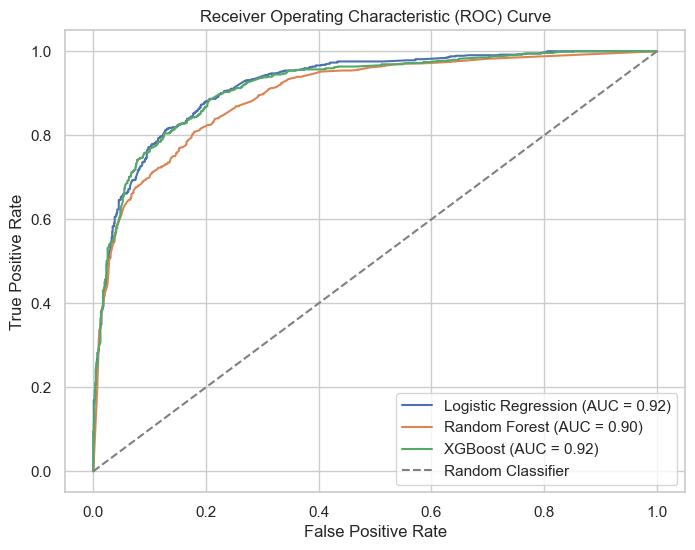

In [94]:
# Plot the ROC curves

plt.figure(figsize=(8, 6))
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {roc_auc_logreg:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_xgboost, tpr_xgboost, label=f'XGBoost (AUC = {roc_auc_xgboost:.2f})')

# Plot the 45-degree line (random classifier)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')

# Set labels and title

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()